In [1]:
import json
import os
from datetime import datetime, timedelta
import pandas as pd
from mmengine.config import Config

In [2]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)

In [3]:
current_dir = os.getcwd()

def listdir(*rel_paths):
    return os.listdir(os.path.join(current_dir, *rel_paths))

def isdir(*rel_paths):
    return os.path.isdir(os.path.join(current_dir, *rel_paths))

def join(*rel_paths):
    return os.path.join(current_dir, *rel_paths)

def isfile(*rel_paths):
    return os.path.isfile(join(*rel_paths))


def get_log_runs():
    work_dirs = [d for d in os.listdir() if isdir(d)]
    print(f'work dirs: {len(work_dirs)}')
    log_runs = [(work_dir, d) for work_dir in work_dirs for d in listdir(work_dir) if isdir(work_dir,d)]
    print(f'log runs: {len(log_runs)}')
    return log_runs


def started_train_run(work_dir, d):
    return isfile(work_dir, d, 'vis_data', f'{d}.json')

def get_logs_df():
    log_runs = get_log_runs()
    return pd.DataFrame(log_runs, columns=['work_dir', 'log_run'])

I want to get the following information, if possible:
- filter for train runs, not test
- config contents
    - model
        - hyperparameters (batch size, learning rate, weight decay, momentum, prompt depth)
        - loss function and class weights
    - dataset

- total time spent during training
- percentage of trainable parameters
    - trainable parameters
    - total parameters
- for training runs:
    - training curve
    - validation curve
    - memory profile
    - whether there is a corresponding test run?
- for test runs:
    - test results
    - test mode (slide or whole)

In [4]:
def load_config(logs_row):
    return Config.fromfile(join(logs_row['work_dir'], logs_row['log_run'], 'config.py'))

def extract_pretrain_config_info(logs):
    def get_checkpoint(row):
        if row['config'].model.backbone.init_cfg.type == 'Pretrained':
            return row['config'].model.backbone.init_cfg.checkpoint
        return None
    def get_load_from(row):
        return row['config'].load_from if row['config'].load_from is not None else ''
    logs['checkpoint'] = logs.apply(get_checkpoint, axis=1)
    logs['load_from'] = logs.apply(get_load_from, axis=1)
    return logs

def extract_prompt_config_info(logs):
    logs['prompt_depth'] = logs.apply(lambda row: row['config'].model.backbone.prompt_cfg.depth if row['backbone'] == 'PromptedVisionTransformer' else None, axis=1)
    logs['prompt_length'] = logs.apply(lambda row: row['config'].model.backbone.prompt_cfg.length if row['backbone'] == 'PromptedVisionTransformer' else None , axis=1)
    logs['prompt_dropout'] = logs.apply(lambda row: row['config'].model.backbone.prompt_cfg.dropout if row['backbone'] == 'PromptedVisionTransformer' else None, axis=1)
    return logs

def extract_memory_file(logs):
    memory_files = logs.apply(lambda row: join(row['work_dir'], row['log_run'], 'memory_snapshot.pickle'), axis=1)
    logs['memory_file'] = memory_files.apply(lambda path: path if isfile(path) else None)
    return logs
    
def extract_config_info(logs):
    configs = logs_df.apply(load_config, axis=1)
    logs_df['config'] = configs
    logs['backbone'] = configs.apply(lambda config: config.model.backbone.type)
    logs['pretrained'] = configs.apply(lambda config: config.model.backbone.init_cfg.type == 'Pretrained')
    logs = extract_pretrain_config_info(logs)
    logs['auxhead'] = configs.apply(lambda config: len(config.model.auxiliary_head) > 0)
    logs['train_dataset'] = configs.apply(lambda config: config.train_dataloader.dataset.type)
    logs['train_iters'] = configs.apply(lambda config: config.train_cfg.max_iters)
    logs['test_dataset'] = configs.apply(lambda config: config.test_dataloader.dataset.type)
    logs['test_mode'] = configs.apply(lambda config: config.model.test_cfg.mode)
    # typical hyperparameters
    logs['batch_size'] = configs.apply(lambda config: config.train_dataloader.batch_size)
    logs['learning_rate'] = configs.apply(lambda config: config.optimizer.lr)
    logs['weight_decay'] = configs.apply(lambda config: config.optimizer.weight_decay)
    logs['momentum'] = configs.apply(lambda config: config.optimizer.momentum)
    # loss related info
    logs['decode_loss_name'] = configs.apply(lambda config: config.model.decode_head.loss_decode.type)
    logs['class_weight'] = configs.apply(lambda config: tuple(config.model.decode_head.loss_decode.get('class_weight', [])))
    logs = extract_prompt_config_info(logs)
    logs = extract_memory_file(logs)
    logs = logs.drop(columns=['config'])
    return logs


def readlogs(row):
    with open(join(row['work_dir'], row['log_run'], f'{row["log_run"]}.log'), 'r') as f:
        return f.readlines()

def extract_total_parameters(log_contents):
    for line in log_contents:
        if 'Total parameters' in line:
            return int(line.split('Total parameters: ')[1].strip())
    return None

def extract_trainable_parameters(log_contents):
    for line in log_contents:
        if 'Trainable parameters' in line:
            return int(line.split('Trainable parameters: ')[1].strip())
    return None

def extract_time_at_index(log_contents, index):
    line = log_contents[index]
    return datetime.strptime(line.split('- mmengine -')[0].strip(), '%Y/%m/%d %H:%M:%S')

def extract_start_time(log_contents):
    return extract_time_at_index(log_contents, 0)

def extract_end_time(log_contents):
    return extract_time_at_index(log_contents, -1)

def extract_log_info(logs):
    log_contents = logs.apply(readlogs, axis=1)
    logs['total_parameters'] = log_contents.apply(extract_total_parameters)
    logs['trainable_parameters'] = log_contents.apply(extract_trainable_parameters)
    logs['trainable_parameters_percentage'] = logs['trainable_parameters'] / logs['total_parameters']
    logs['duration'] = log_contents.apply(extract_end_time) - log_contents.apply(extract_start_time)
    return logs

def get_train_run_info(row):
    with open(join(row['work_dir'], row['log_run'], 'vis_data', f'{row["log_run"]}.json'), 'r') as f:
        lines = f.readlines()
        parsed_lines = [json.loads(line) for line in lines]
        return [line for line in parsed_lines if line.get('loss') is not None]

def get_val_run_info(row):
    with open(join(row['work_dir'], row['log_run'], 'vis_data', f'{row["log_run"]}.json'), 'r') as f:
        lines = f.readlines()
        parsed_lines = [json.loads(line) for line in lines]
        return [line for line in parsed_lines if line.get('loss') is None]

def get_test_run_info(row):
    if not isdir(row['work_dir'], row['log_run'], 'test'):
        return None
    tests = listdir(row['work_dir'], row['log_run'], 'test')
    if len(tests) == 0:
        return None
    if len(tests) > 1:
        raise ValueError(f'WARNING: more than one test run found for {row["log_run"]}')
    test = tests[0]
    with open(join(row['work_dir'], row['log_run'], 'test', test, f'{test}.json'), 'r') as f:
        lines = f.readlines()
        assert len(lines) == 1
    return json.loads(lines[0])

def get_best_val_info(row):
    val_run_info = row['val_run_info']
    return max(val_run_info, key=lambda x: x['mIoU'])

def extract_run_info(logs):
    train_run_info = logs.apply(get_train_run_info, axis=1)
    val_run_info = logs.apply(get_val_run_info, axis=1)
    test_run_info = logs.apply(get_test_run_info, axis=1)
    logs['train_run_info'] = train_run_info
    logs['val_run_info'] = val_run_info
    logs['test_run_info'] = test_run_info
    
    # get the val info at the point where mIoU was best
    best_val_info = logs.apply(get_best_val_info, axis=1)
    logs['best_val_info'] = best_val_info
    return logs

#todo: also extract per class test results
    

logs_df = get_logs_df()
logs_df = extract_config_info(logs_df)
logs_df = extract_log_info(logs_df)
logs_df = extract_run_info(logs_df)
logs_df = logs_df.sort_values(by=['backbone'])
display(logs_df)

work dirs: 8
log runs: 24


,work_dir,log_run,backbone,pretrained,checkpoint,load_from,auxhead,train_dataset,train_iters,test_dataset,test_mode,batch_size,learning_rate,weight_decay,momentum,decode_loss_name,class_weight,prompt_depth,prompt_length,prompt_dropout,memory_file,total_parameters,trainable_parameters,trainable_parameters_percentage,duration,train_run_info,val_run_info,test_run_info,best_val_info
11,setrvpt_vit-l_pup-noaux_8xb2-160k_ade20k-512x512,20231125_124611,PromptedVisionTransformer,True,pretrain/vit_large_p16.pth,,False,ADE20KDataset,160000,ADE20KDataset,whole,8,0.0005,0.000,0.9,CrossEntropyLoss,(),24.0,50.0,0.1,None,309546646.0,5400214.0,0.017446,3 days 06:57:31,"[{'base_lr': 0.0004998897476225205, 'lr': 0.00...","[{'aAcc': 75.02, 'mIoU': 17.12, 'mAcc': 23.44,...","{'aAcc': 80.87, 'mIoU': 42.8, 'mAcc': 55.02, '...","{'aAcc': 80.87, 'mIoU': 42.8, 'mAcc': 55.02, '..."
21,setrvpt_vit-l_pup_8xb2-160k_cbis-ddsm-binary-5...,20231224_194010,PromptedVisionTransformer,True,pretrain/vit_large_p16.pth,,True,CBISBinaryDataset,160000,CBISBinaryDataset,whole,4,0.0100,0.001,0.9,CrossEntropyLoss,"(0.04, 1.96)",24.0,50.0,0.1,/home/drumsnchocolate/Documents/Studie/Master/...,318366728.0,14220296.0,0.044666,1 days 18:55:15,"[{'base_lr': 0.009997271253657354, 'lr': 0.009...","[{'aAcc': 86.67, 'mIoU': 46.78, 'mAcc': 79.54,...",None,"{'aAcc': 93.75, 'mIoU': 50.8, 'mAcc': 66.44, '..."
20,setrvpt_vit-l_pup_8xb2-160k_cbis-ddsm-binary-5...,20231225_071246,PromptedVisionTransformer,True,pretrain/vit_large_p16.pth,,True,CBISBinaryDataset,160000,CBISBinaryDataset,whole,4,0.0001,0.001,0.9,CrossEntropyLoss,"(0.04, 1.96)",24.0,50.0,0.1,/home/drumsnchocolate/Documents/Studie/Master/...,318366728.0,14220296.0,0.044666,1 days 18:52:56,"[{'base_lr': 0.0001, 'lr': 0.0001, 'data_time'...","[{'aAcc': 89.34, 'mIoU': 48.69, 'mAcc': 78.6, ...",None,"{'aAcc': 97.17, 'mIoU': 54.72, 'mAcc': 63.28, ..."
19,setrvpt_vit-l_pup_8xb2-160k_cbis-ddsm-binary-5...,20231224_192411,PromptedVisionTransformer,True,pretrain/vit_large_p16.pth,,True,CBISBinaryDataset,160000,CBISBinaryDataset,whole,4,0.0500,0.001,0.9,CrossEntropyLoss,"(0.04, 1.96)",24.0,50.0,0.1,/home/drumsnchocolate/Documents/Studie/Master/...,318366728.0,14220296.0,0.044666,1 days 17:35:39,"[{'base_lr': 0.04998624601590929, 'lr': 0.0499...","[{'aAcc': 81.7, 'mIoU': 42.84, 'mAcc': 69.23, ...",None,"{'aAcc': 83.28, 'mIoU': 44.54, 'mAcc': 79.76, ..."
18,setrvpt_vit-l_pup_8xb2-160k_cbis-ddsm-binary-5...,20231225_010141,PromptedVisionTransformer,True,pretrain/vit_large_p16.pth,,True,CBISBinaryDataset,160000,CBISBinaryDataset,whole,4,0.0005,0.001,0.9,CrossEntropyLoss,"(0.04, 1.96)",24.0,50.0,0.1,/home/drumsnchocolate/Documents/Studie/Master/...,318366728.0,14220296.0,0.044666,1 days 18:36:33,"[{'base_lr': 0.0004998897476225205, 'lr': 0.00...","[{'aAcc': 90.11, 'mIoU': 49.25, 'mAcc': 78.05,...",None,"{'aAcc': 97.98, 'mIoU': 55.67, 'mAcc': 60.67, ..."
17,setrvpt_vit-l_pup_8xb2-160k_cbis-ddsm-binary-5...,20231212_141502,PromptedVisionTransformer,True,pretrain/vit_large_p16.pth,,True,CBISBinaryDataset,160000,CBISBinaryDataset,whole,4,0.1000,0.001,0.9,CrossEntropyLoss,"(0.04, 1.96)",24.0,50.0,0.1,/home/drumsnchocolate/Documents/Studie/Master/...,318366728.0,14220296.0,0.044666,1 days 17:04:25,"[{'base_lr': 0.09997246446872429, 'lr': 0.0999...","[{'aAcc': 81.58, 'mIoU': 42.97, 'mAcc': 72.16,...","{'aAcc': 79.71, 'mIoU': 41.63, 'mAcc': 71.34, ...","{'aAcc': 94.83, 'mIoU': 51.01, 'mAcc': 62.29, ..."
16,setrvpt_vit-l_pup_8xb2-160k_cbis-ddsm-binary-5...,20231224_194855,PromptedVisionTransformer,True,pretrain/vit_large_p16.pth,,True,CBISBinaryDataset,160000,CBISBinaryDataset,whole,4,0.0050,0.001,0.9,CrossEntropyLoss,"(0.04, 1.96)",24.0,50.0,0.1,/home/drumsnchocolate/Documents/Studie/Master/...,318366728.0,14220296.0,0.044666,1 days 18:07:18,"[{'base_lr': 0.0049986494083758635, 'lr': 0.00...","[{'aAcc': 94.61, 'mIoU': 52.06, 'mAcc': 68.05,...",None,"{'aAcc': 94.61, 'mIoU': 52.06, 'mAcc': 68.05, ..."
15,setrvpt_vit-l_pup_8xb2-160k_cbis-ddsm-binary-

# Displaying training curves, test results

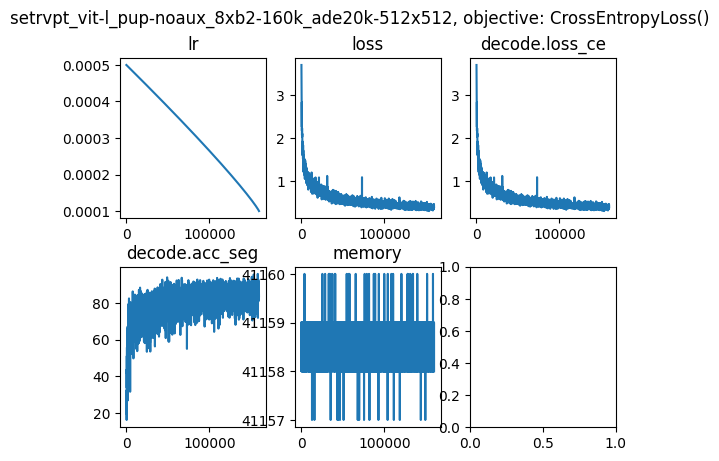

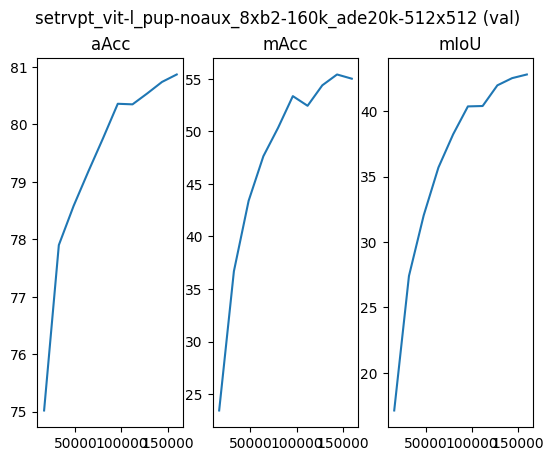

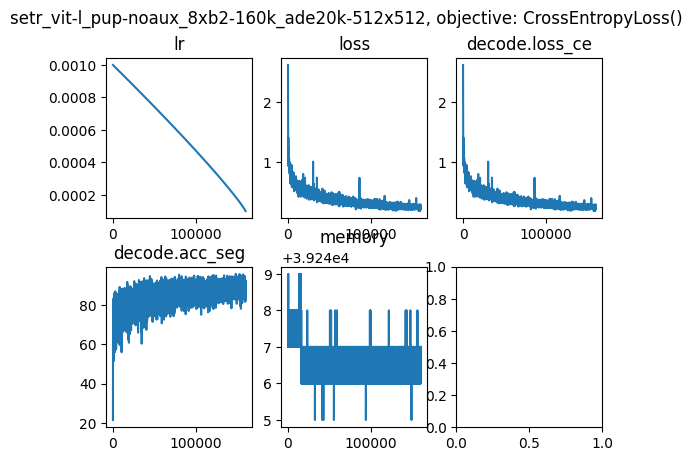

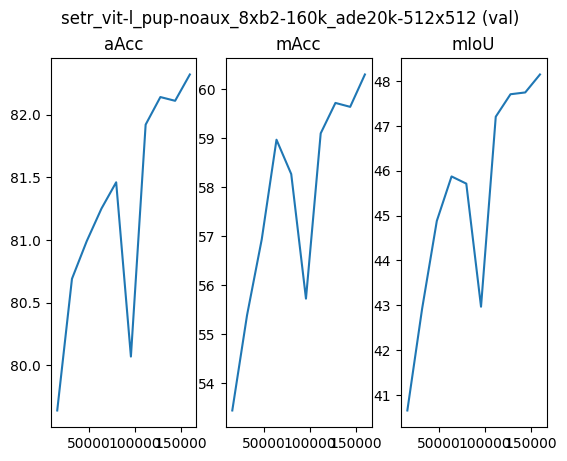

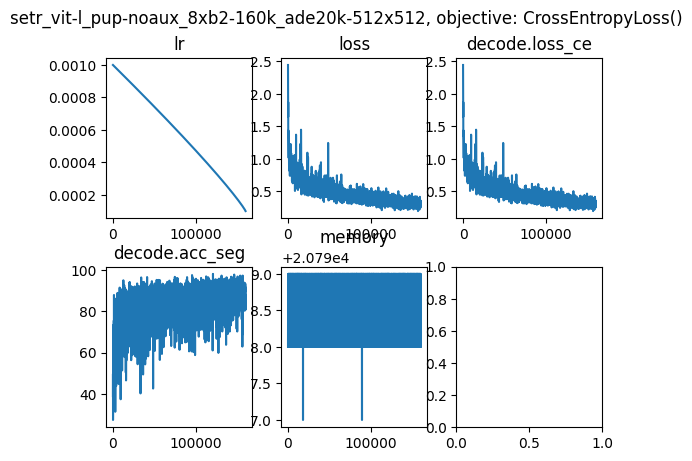

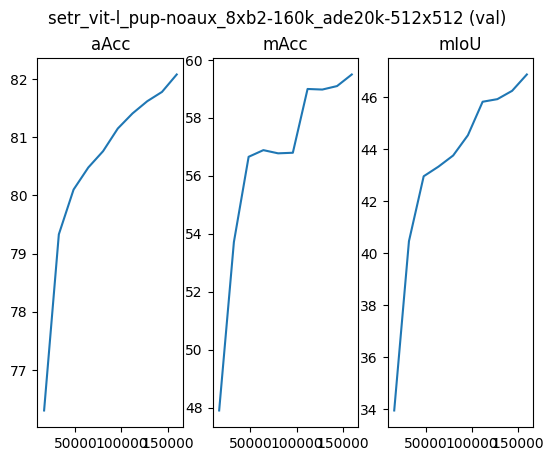

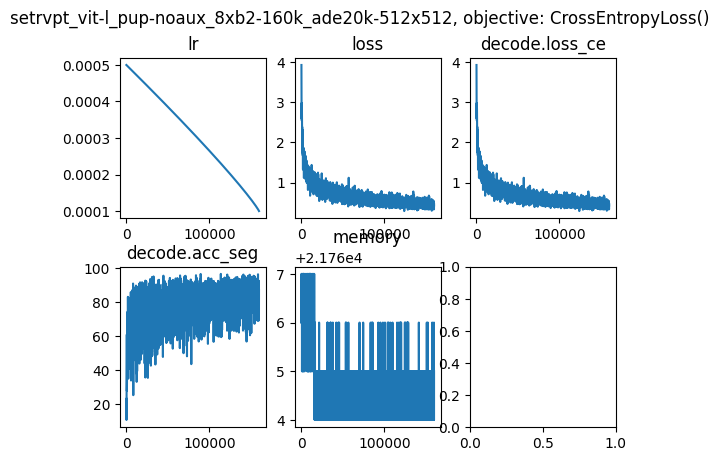

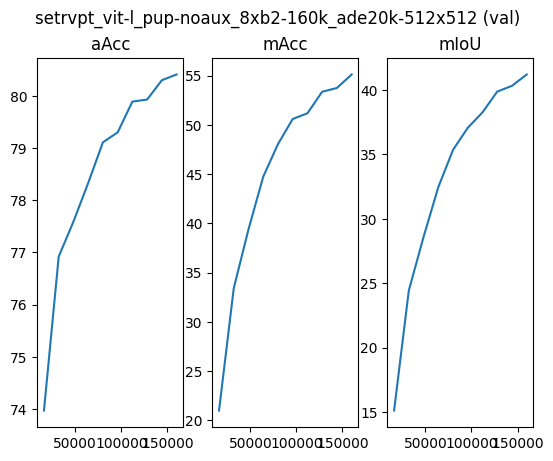

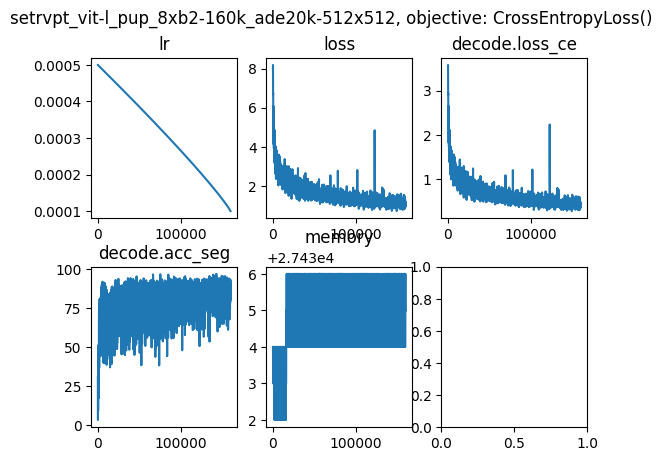

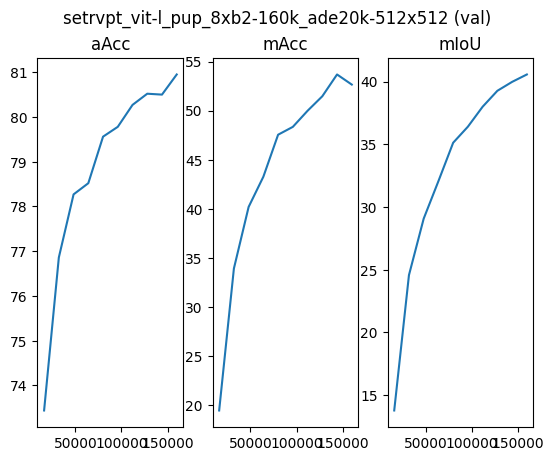

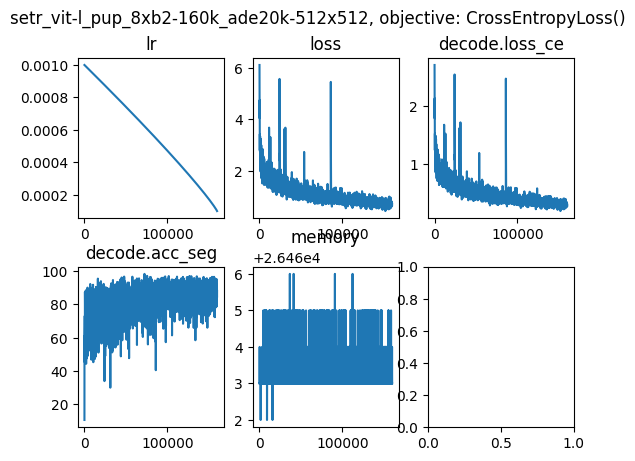

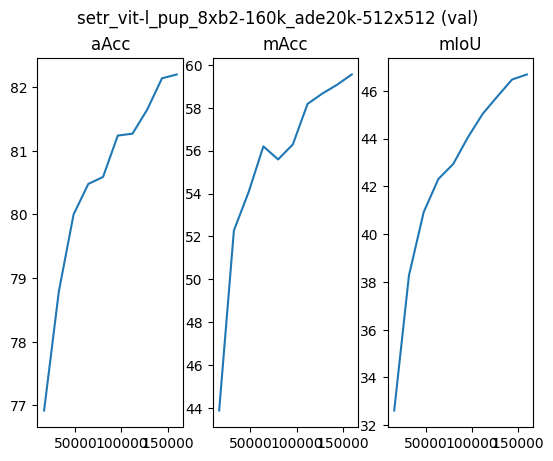

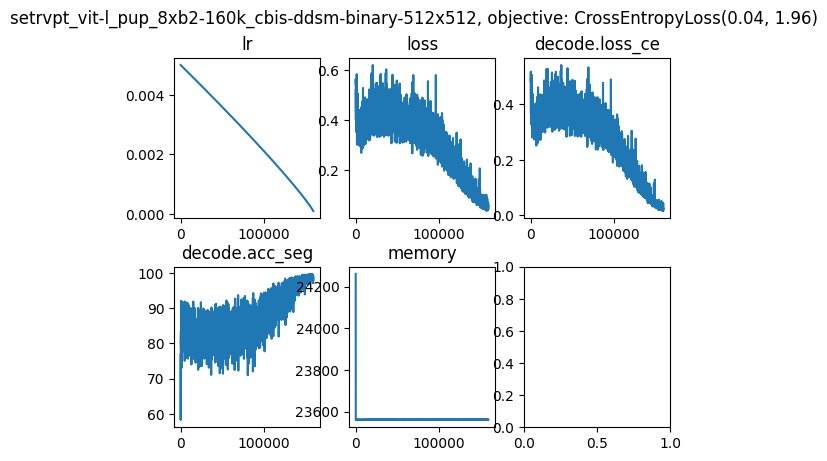

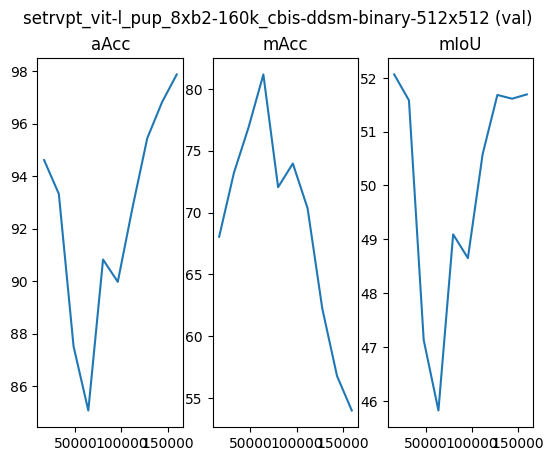

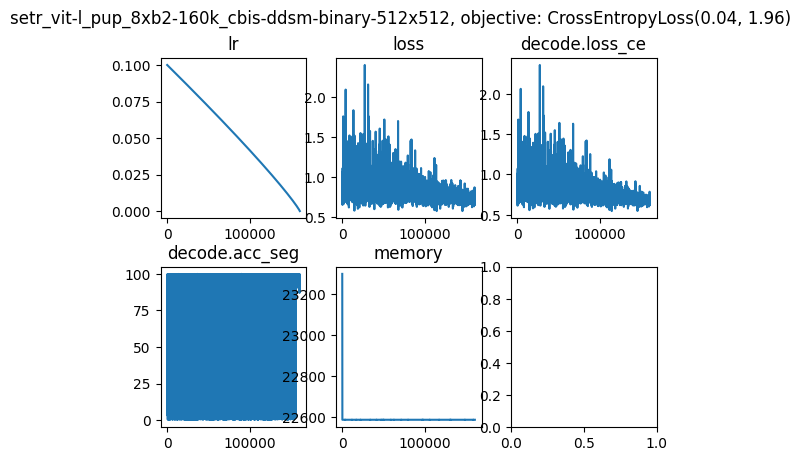

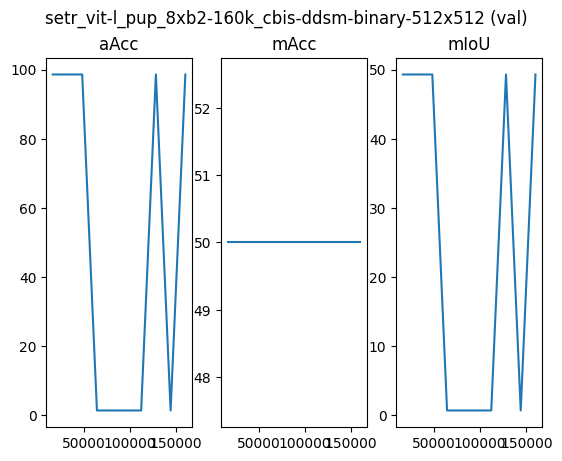

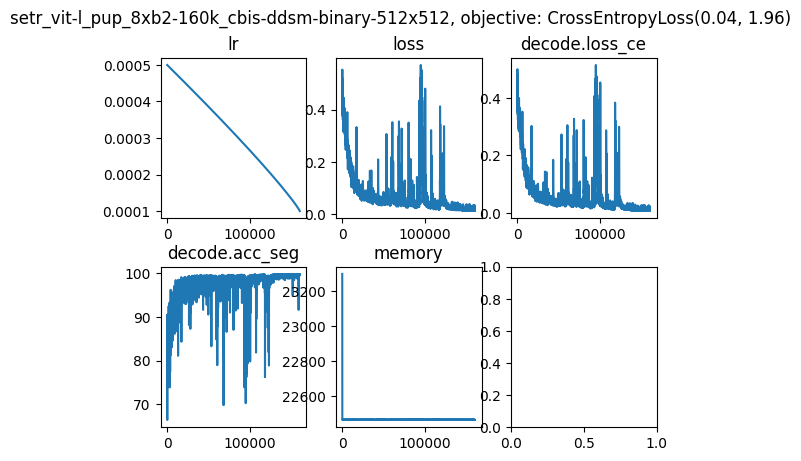

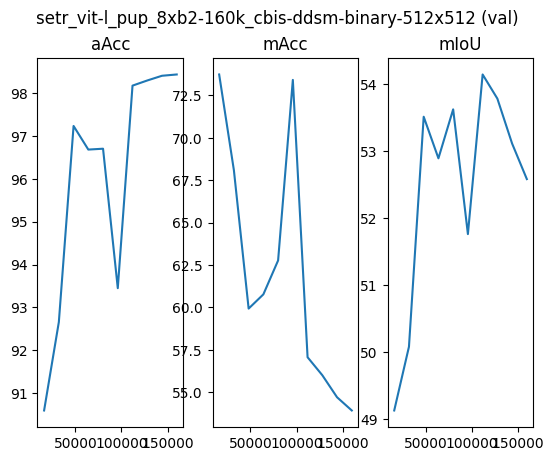

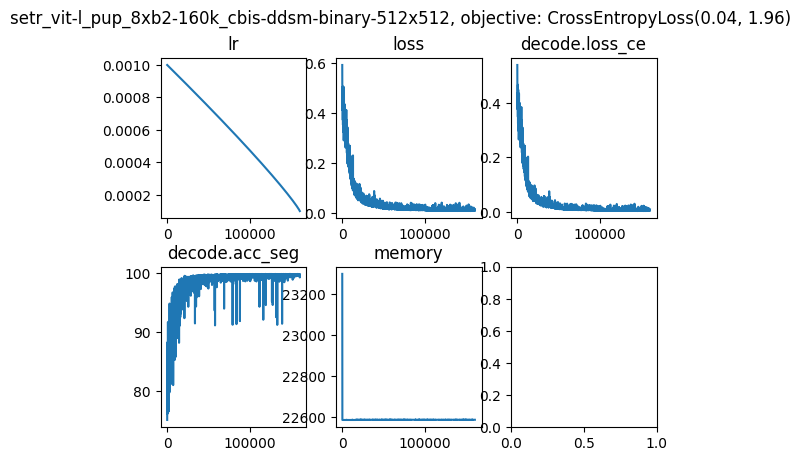

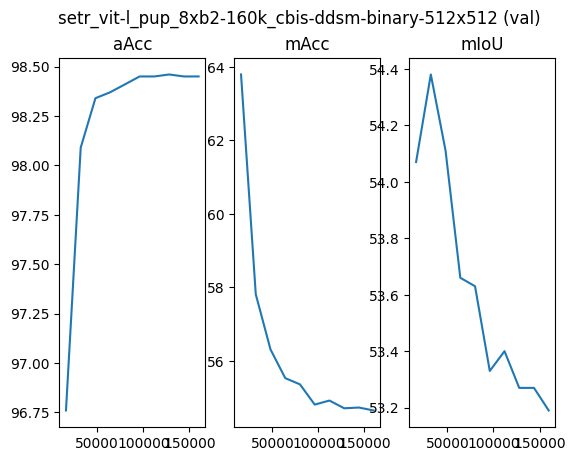

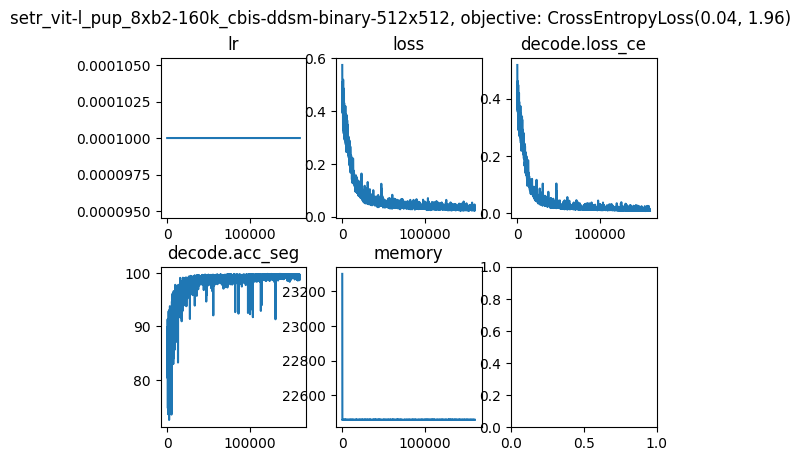

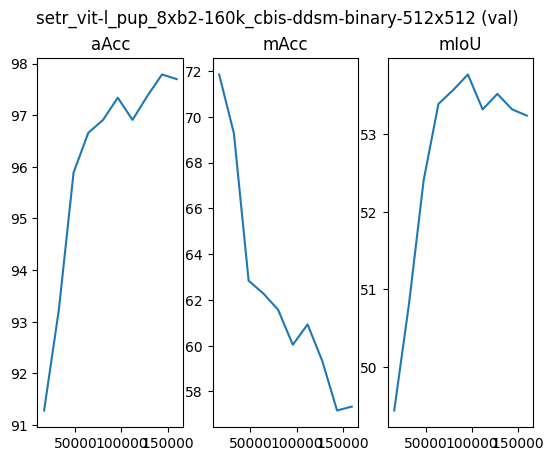

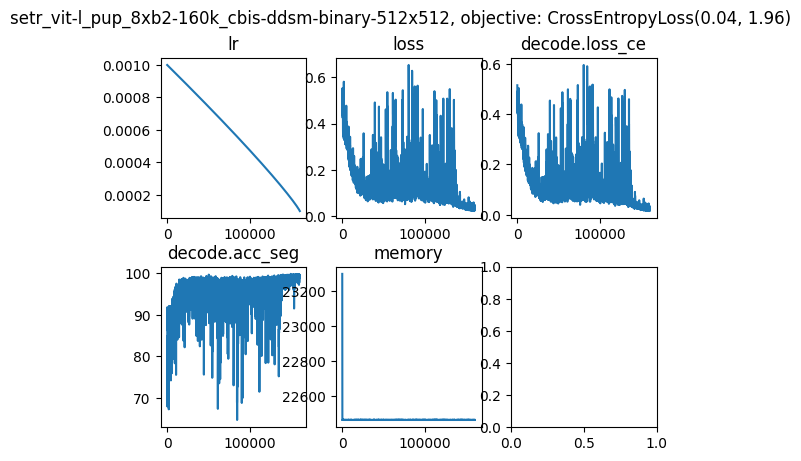

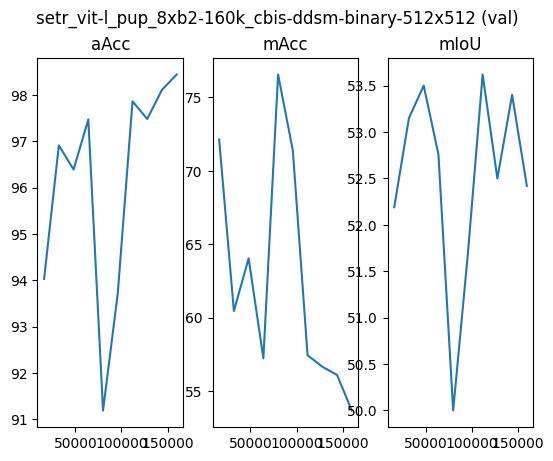

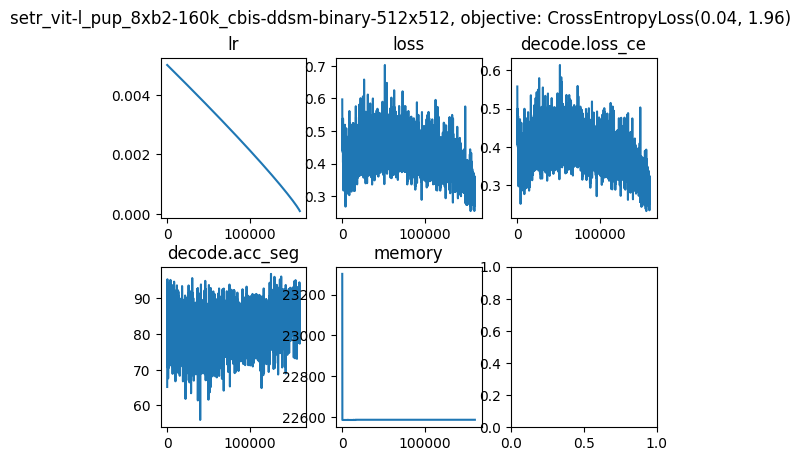

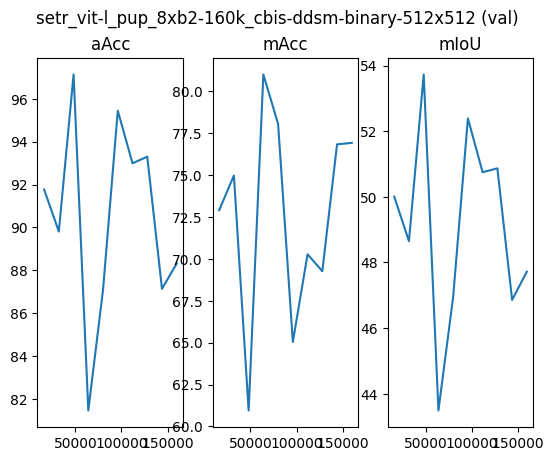

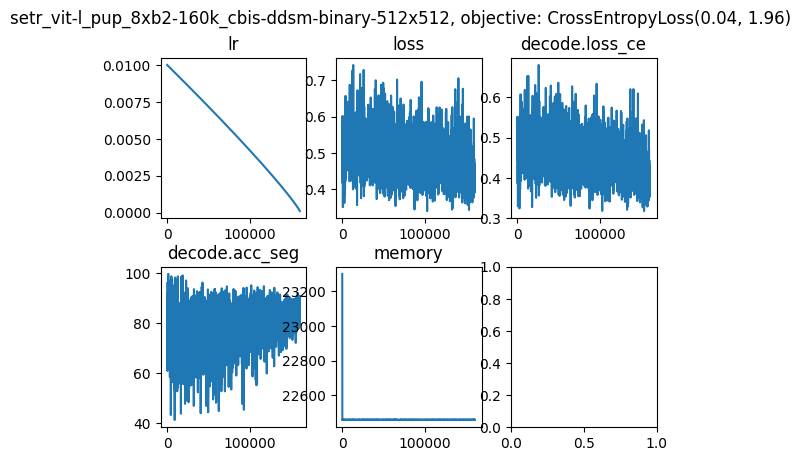

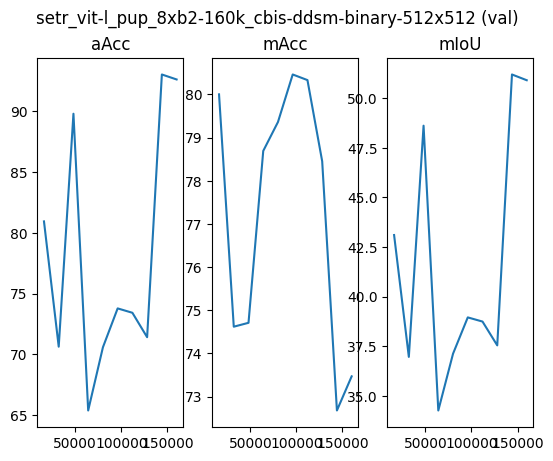

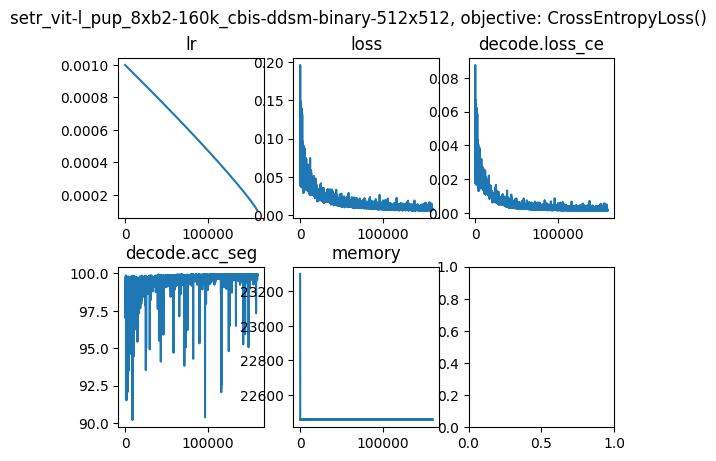

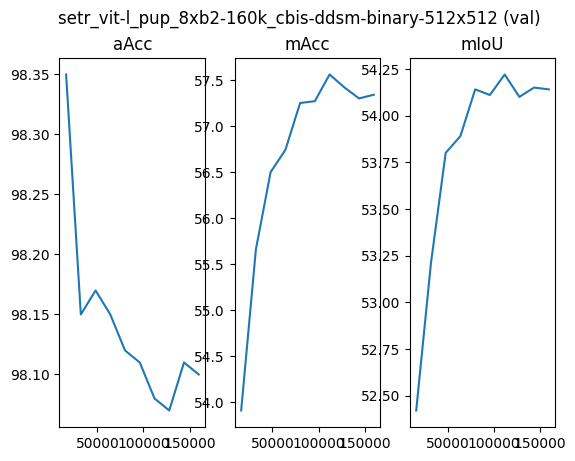

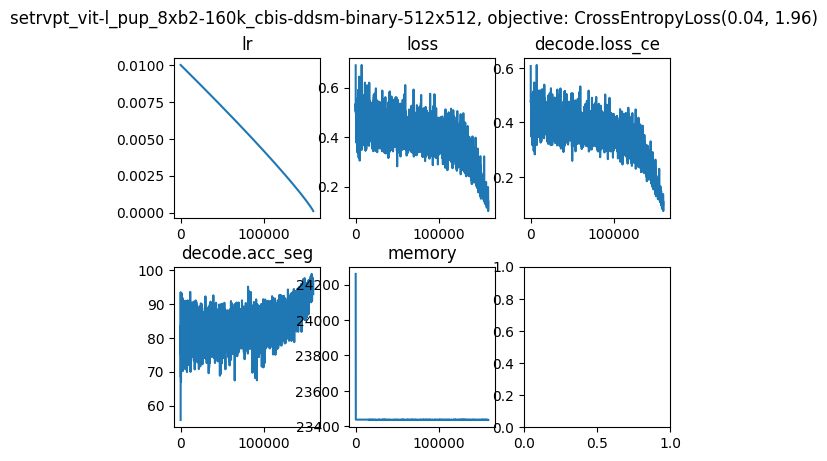

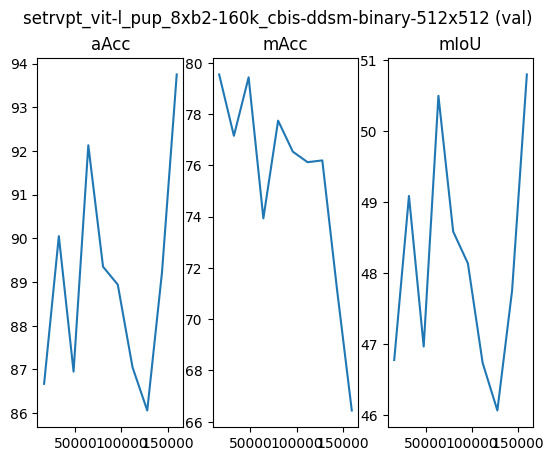

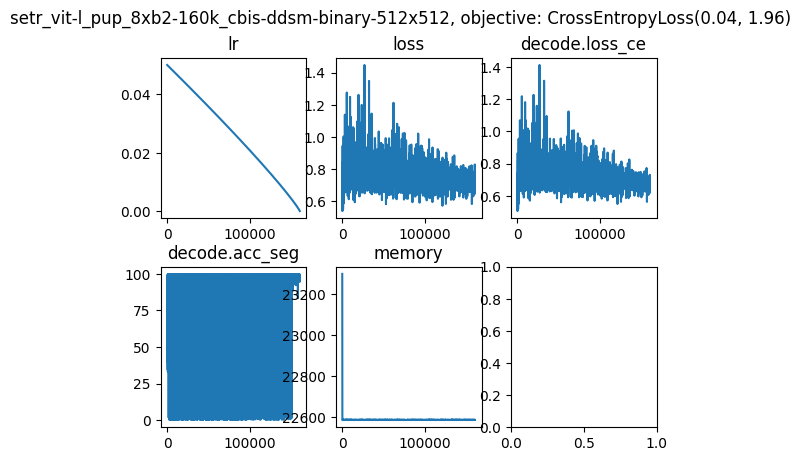

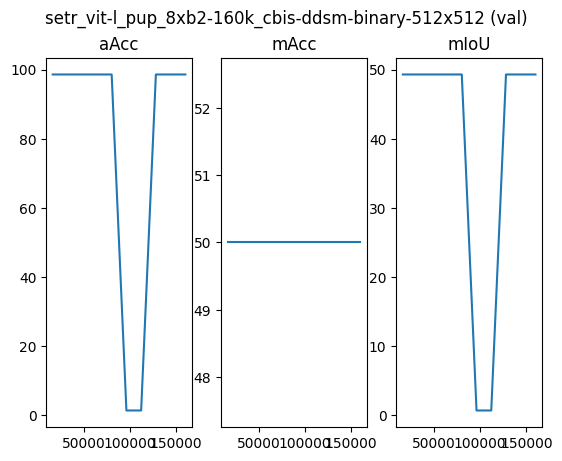

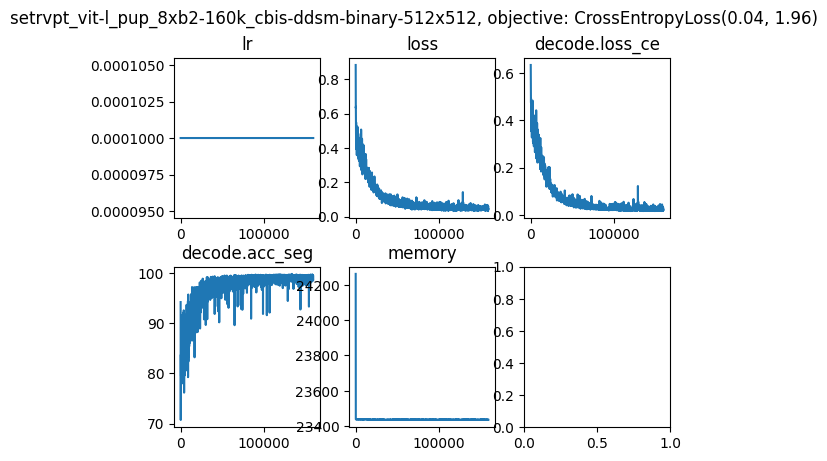

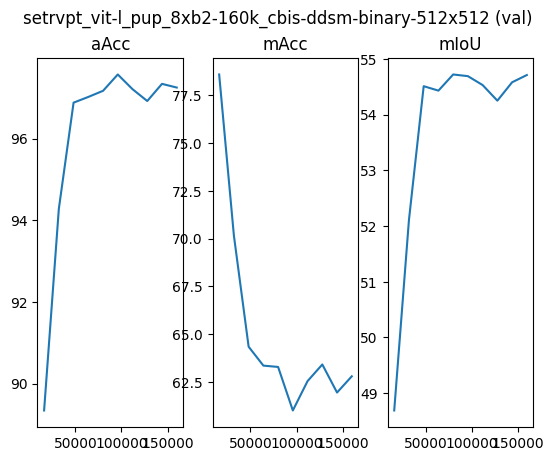

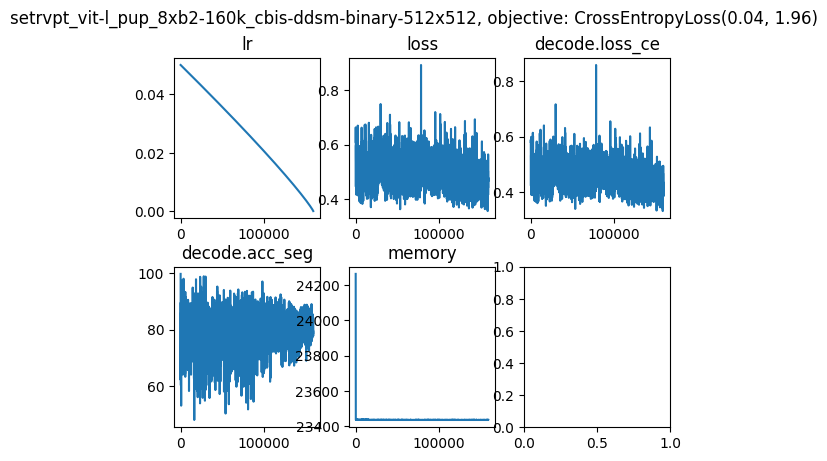

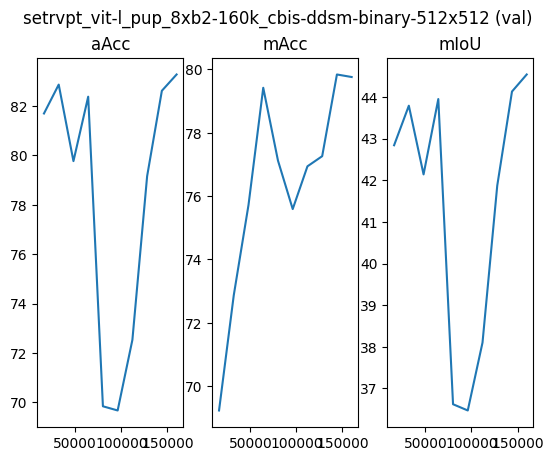

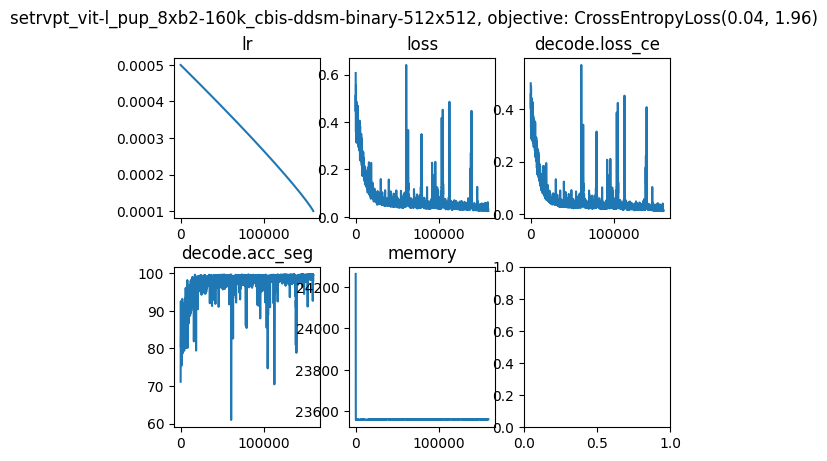

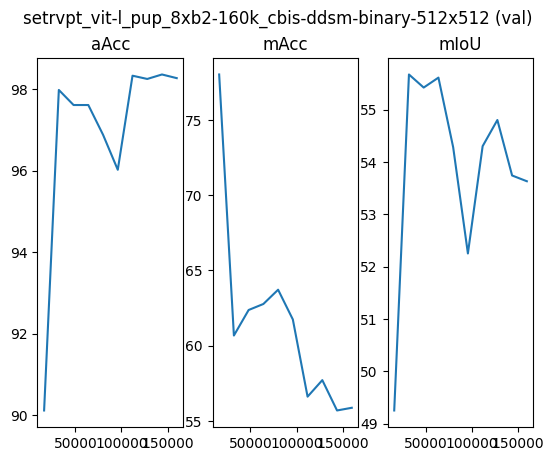

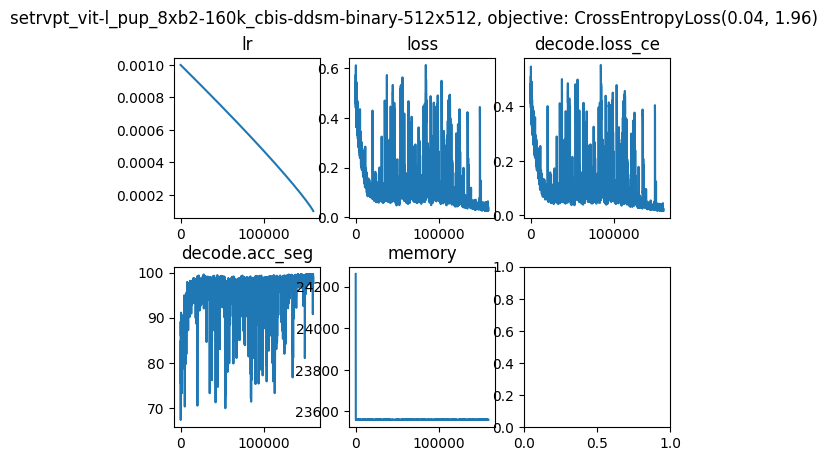

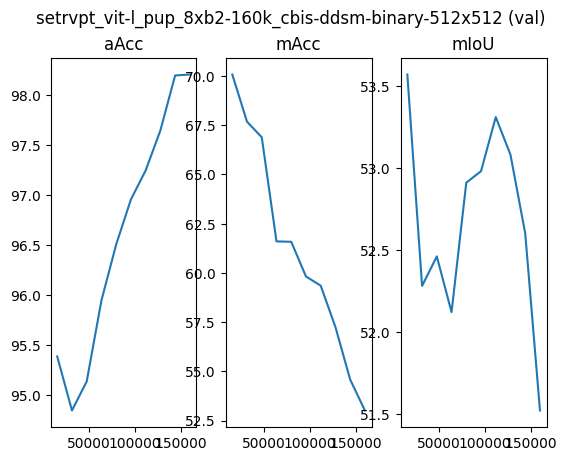

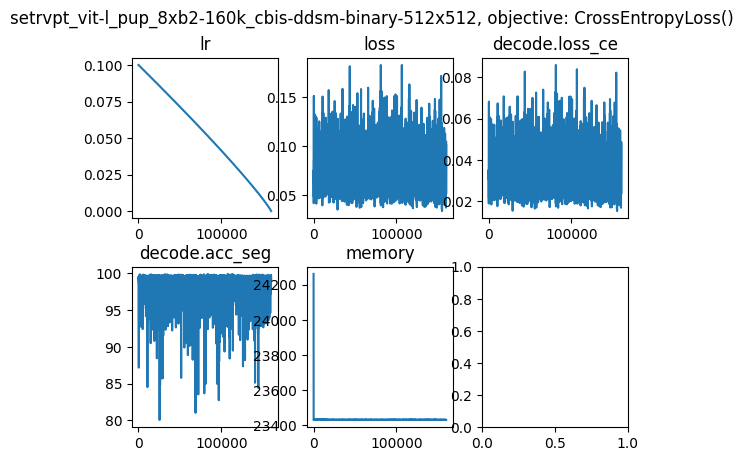

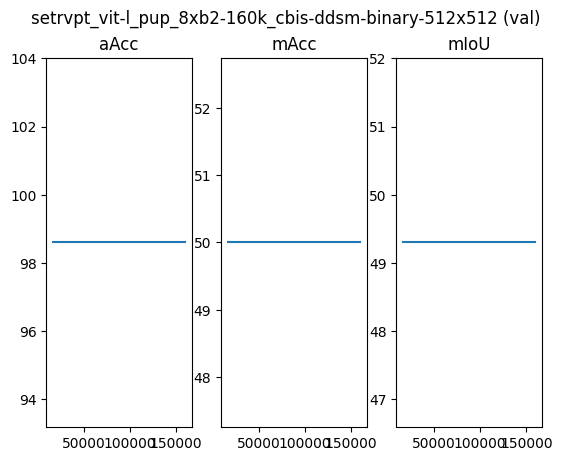

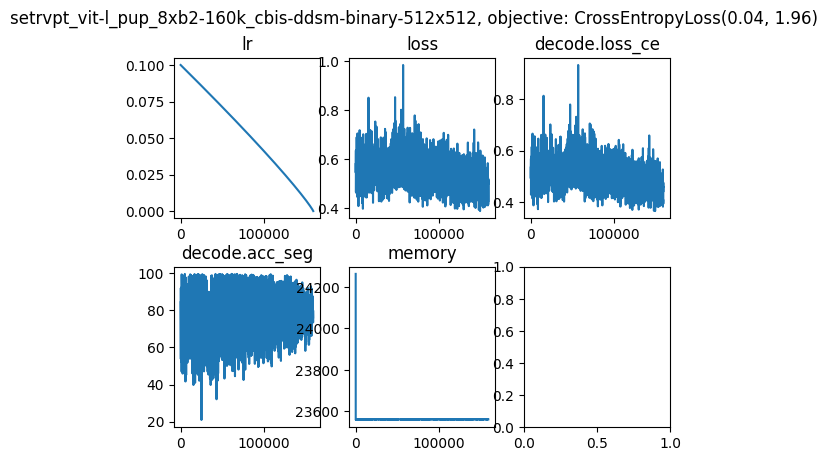

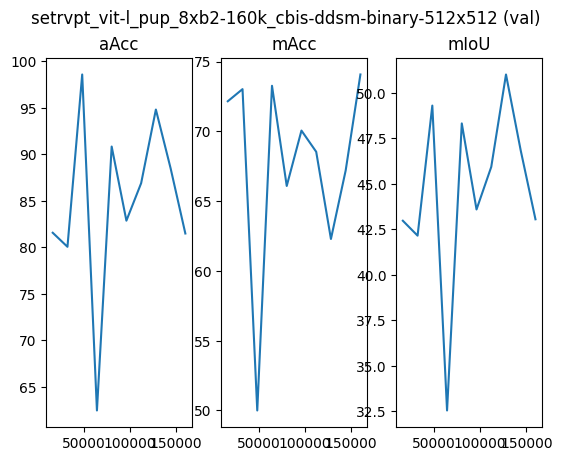

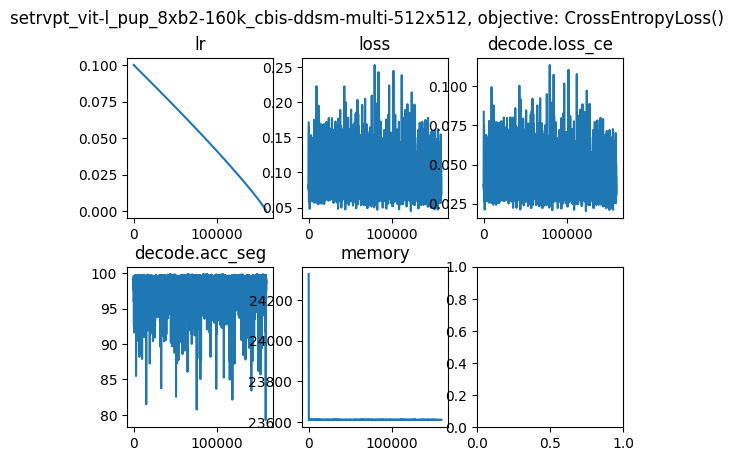

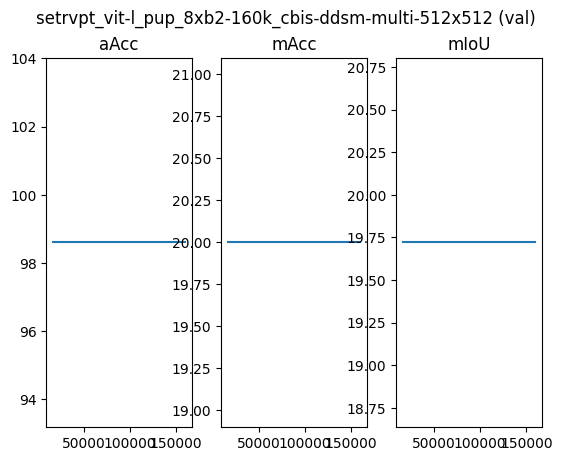

11    None
9     None
10    None
12    None
13    None
23    None
16    None
1     None
2     None
3     None
4     None
5     None
6     None
7     None
8     None
21    None
0     None
20    None
19    None
18    None
14    None
15    None
17    None
22    None
dtype: object

In [5]:
# first, we plot a training curve for each run
import matplotlib.pyplot as plt
import numpy as np

def plot_train_run_info(row):
    train_run_info = row['train_run_info']
    train_df = pd.DataFrame(train_run_info)
    # let's just plot the following columns out of curiosity:
    # lr, loss, decode.loss_ce, decode.acc_seg, memory\
    fig, axes = plt.subplots(nrows=2, ncols=3, gridspec_kw={"hspace": 0.3})
    fig.suptitle(f"{row['work_dir']}, objective: {row['decode_loss_name']}{row['class_weight'] if row['class_weight'] is not None else ''}")
    for i, c in enumerate(['lr', 'loss', 'decode.loss_ce', 'decode.acc_seg', 'memory']):
        ax = axes[i//3, i%3]
        ax.plot(train_df['step'], train_df[c])
        ax.set_title(c)
    plt.show()

def plot_val_run_info(row):
    val_run_info = row['val_run_info']
    val_df = pd.DataFrame(val_run_info)
    # let's just plot the following columns out of curiosity:
    # aAcc, mAcc, mIoU
    fig, axes = plt.subplots(nrows=1, ncols=3, gridspec_kw={"hspace": 0.3})
    fig.suptitle(f'{row["work_dir"]} (val)')
    for i, c in enumerate(['aAcc', 'mAcc', 'mIoU']):
        ax = axes[i]
        ax.plot(val_df['step'], val_df[c])
        ax.set_title(c)
    plt.show()
    
def plot_run_info(row):
    plot_train_run_info(row)
    plot_val_run_info(row)

logs_df.sort_values('train_dataset').apply(plot_run_info, axis=1)

Index(['work_dir', 'log_run', 'backbone', 'pretrained', 'checkpoint',
       'load_from', 'auxhead', 'train_dataset', 'train_iters', 'test_dataset',
       'test_mode', 'batch_size', 'learning_rate', 'weight_decay', 'momentum',
       'decode_loss_name', 'class_weight', 'prompt_depth', 'prompt_length',
       'prompt_dropout', 'memory_file', 'total_parameters',
       'trainable_parameters', 'trainable_parameters_percentage', 'duration',
       'train_run_info', 'val_run_info', 'test_run_info', 'best_val_info'],
      dtype='object')


,work_dir,log_run,backbone,pretrained,checkpoint,load_from,auxhead,train_dataset,train_iters,test_dataset,test_mode,batch_size,learning_rate,weight_decay,momentum,decode_loss_name,class_weight,prompt_depth,prompt_length,prompt_dropout,memory_file,total_parameters,trainable_parameters,trainable_parameters_percentage,duration,train_run_info,val_run_info,test_run_info,best_val_info
11,setrvpt_vit-l_pup-noaux_8xb2-160k_ade20k-512x512,20231125_124611,PromptedVisionTransformer,True,pretrain/vit_large_p16.pth,,False,ADE20KDataset,160000,ADE20KDataset,whole,8,0.0005,0.0,0.9,CrossEntropyLoss,(),24.0,50.0,0.1,None,309546646.0,5400214.0,0.017446,3 days 06:57:31,"[{'base_lr': 0.0004998897476225205, 'lr': 0.00...","[{'aAcc': 75.02, 'mIoU': 17.12, 'mAcc': 23.44,...","{'aAcc': 80.87, 'mIoU': 42.8, 'mAcc': 55.02, '...","{'aAcc': 80.87, 'mIoU': 42.8, 'mAcc': 55.02, '..."
12,setrvpt_vit-l_pup-noaux_8xb2-160k_ade20k-512x512,20231208_113210,PromptedVisionTransformer,True,pretrain/vit_large_p16.pth,,False,ADE20KDataset,160000,ADE20KDataset,whole,4,0.0005,0.0,0.9,CrossEntropyLoss,(),24.0,50.0,0.1,None,309546646.0,5400214.0,0.017446,1 days 16:37:39,"[{'base_lr': 0.0004998897476225205, 'lr': 0.00...","[{'aAcc': 73.97, 'mIoU': 15.11, 'mAcc': 21.0, ...","{'aAcc': 80.41, 'mIoU': 41.2, 'mAcc': 55.12, '...","{'aAcc': 80.41, 'mIoU': 41.2, 'mAcc': 55.12, '..."


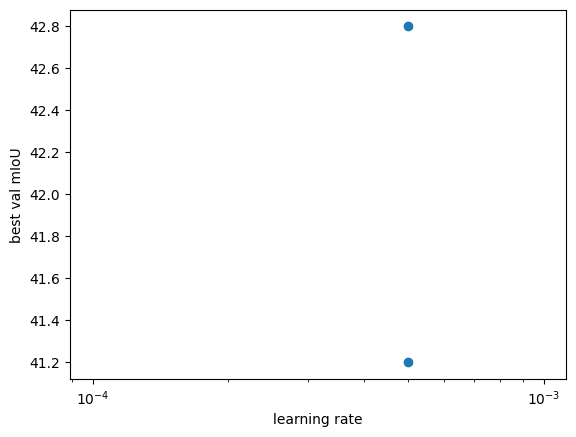

,work_dir,log_run,backbone,pretrained,checkpoint,load_from,auxhead,train_dataset,train_iters,test_dataset,test_mode,batch_size,learning_rate,weight_decay,momentum,decode_loss_name,class_weight,prompt_depth,prompt_length,prompt_dropout,memory_file,total_parameters,trainable_parameters,trainable_parameters_percentage,duration,train_run_info,val_run_info,test_run_info,best_val_info
21,setrvpt_vit-l_pup_8xb2-160k_cbis-ddsm-binary-5...,20231224_194010,PromptedVisionTransformer,True,pretrain/vit_large_p16.pth,,True,CBISBinaryDataset,160000,CBISBinaryDataset,whole,4,0.0100,0.001,0.9,CrossEntropyLoss,"(0.04, 1.96)",24.0,50.0,0.1,/home/drumsnchocolate/Documents/Studie/Master/...,318366728.0,14220296.0,0.044666,1 days 18:55:15,"[{'base_lr': 0.009997271253657354, 'lr': 0.009...","[{'aAcc': 86.67, 'mIoU': 46.78, 'mAcc': 79.54,...",None,"{'aAcc': 93.75, 'mIoU': 50.8, 'mAcc': 66.44, '..."
20,setrvpt_vit-l_pup_8xb2-160k_cbis-ddsm-binary-5...,20231225_071246,PromptedVisionTransformer,True,pretrain/vit_large_p16.pth,,True,CBISBinaryDataset,160000,CBISBinaryDataset,whole,4,0.0001,0.001,0.9,CrossEntropyLoss,"(0.04, 1.96)",24.0,50.0,0.1,/home/drumsnchocolate/Documents/Studie/Master/...,318366728.0,14220296.0,0.044666,1 days 18:52:56,"[{'base_lr': 0.0001, 'lr': 0.0001, 'data_time'...","[{'aAcc': 89.34, 'mIoU': 48.69, 'mAcc': 78.6, ...",None,"{'aAcc': 97.17, 'mIoU': 54.72, 'mAcc': 63.28, ..."
19,setrvpt_vit-l_pup_8xb2-160k_cbis-ddsm-binary-5...,20231224_192411,PromptedVisionTransformer,True,pretrain/vit_large_p16.pth,,True,CBISBinaryDataset,160000,CBISBinaryDataset,whole,4,0.0500,0.001,0.9,CrossEntropyLoss,"(0.04, 1.96)",24.0,50.0,0.1,/home/drumsnchocolate/Documents/Studie/Master/...,318366728.0,14220296.0,0.044666,1 days 17:35:39,"[{'base_lr': 0.04998624601590929, 'lr': 0.0499...","[{'aAcc': 81.7, 'mIoU': 42.84, 'mAcc': 69.23, ...",None,"{'aAcc': 83.28, 'mIoU': 44.54, 'mAcc': 79.76, ..."
18,setrvpt_vit-l_pup_8xb2-160k_cbis-ddsm-binary-5...,20231225_010141,PromptedVisionTransformer,True,pretrain/vit_large_p16.pth,,True,CBISBinaryDataset,160000,CBISBinaryDataset,whole,4,0.0005,0.001,0.9,CrossEntropyLoss,"(0.04, 1.96)",24.0,50.0,0.1,/home/drumsnchocolate/Documents/Studie/Master/...,318366728.0,14220296.0,0.044666,1 days 18:36:33,"[{'base_lr': 0.0004998897476225205, 'lr': 0.00...","[{'aAcc': 90.11, 'mIoU': 49.25, 'mAcc': 78.05,...",None,"{'aAcc': 97.98, 'mIoU': 55.67, 'mAcc': 60.67, ..."
17,setrvpt_vit-l_pup_8xb2-160k_cbis-ddsm-binary-5...,20231212_141502,PromptedVisionTransformer,True,pretrain/vit_large_p16.pth,,True,CBISBinaryDataset,160000,CBISBinaryDataset,whole,4,0.1000,0.001,0.9,CrossEntropyLoss,"(0.04, 1.96)",24.0,50.0,0.1,/home/drumsnchocolate/Documents/Studie/Master/...,318366728.0,14220296.0,0.044666,1 days 17:04:25,"[{'base_lr': 0.09997246446872429, 'lr': 0.0999...","[{'aAcc': 81.58, 'mIoU': 42.97, 'mAcc': 72.16,...","{'aAcc': 79.71, 'mIoU': 41.63, 'mAcc': 71.34, ...","{'aAcc': 94.83, 'mIoU': 51.01, 'mAcc': 62.29, ..."
16,setrvpt_vit-l_pup_8xb2-160k_cbis-ddsm-binary-5...,20231224_194855,PromptedVisionTransformer,True,pretrain/vit_large_p16.pth,,True,CBISBinaryDataset,160000,CBISBinaryDataset,whole,4,0.0050,0.001,0.9,CrossEntropyLoss,"(0.04, 1.96)",24.0,50.0,0.1,/home/drumsnchocolate/Documents/Studie/Master/...,318366728.0,14220296.0,0.044666,1 days 18:07:18,"[{'base_lr': 0.0049986494083758635, 'lr': 0.00...","[{'aAcc': 94.61, 'mIoU': 52.06, 'mAcc': 68.05,...",None,"{'aAcc': 94.61, 'mIoU': 52.06, 'mAcc': 68.05, ..."
14,setrvpt_vit-l_pup_8xb2-160k_cbis-ddsm-binary-5...,20231224_210838,PromptedVisionTransformer,True,pretrain/vit_large_p16.pth,,True,CBISBinaryDataset,160000,CBISBinaryDataset,whole,4,0.0010,0.001,0.9,CrossEntropyLoss,"(0.04, 1.96)",24.0,50.0,0.1,/home/drumsnchocolate/Documents/Studie/Master/...,318366728.0,14220296.0,0.044666,1 days 17:55:51,"[{'base_lr': 0.000999751932150666, 'lr': 0.000...","[{'aAcc': 95.39, 'mIoU': 53.57, 'mAcc': 70.08,...",None,"{'aAcc': 95.39, 'mIoU': 53.57, 'mAcc': 70.08, ..."


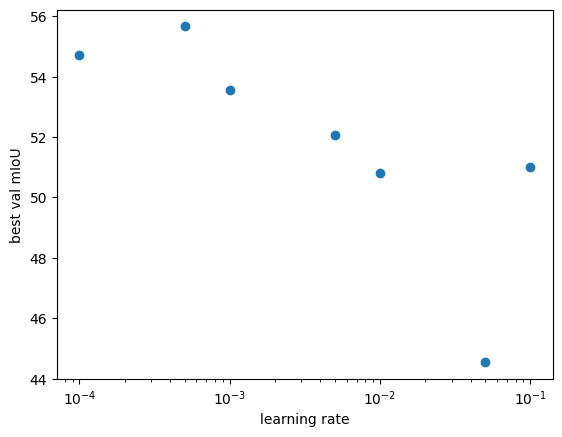

,work_dir,log_run,backbone,pretrained,checkpoint,load_from,auxhead,train_dataset,train_iters,test_dataset,test_mode,batch_size,learning_rate,weight_decay,momentum,decode_loss_name,class_weight,prompt_depth,prompt_length,prompt_dropout,memory_file,total_parameters,trainable_parameters,trainable_parameters_percentage,duration,train_run_info,val_run_info,test_run_info,best_val_info
15,setrvpt_vit-l_pup_8xb2-160k_cbis-ddsm-binary-5...,20231211_141239,PromptedVisionTransformer,True,pretrain/vit_large_p16.pth,,True,CBISBinaryDataset,160000,CBISBinaryDataset,whole,4,0.1,0.001,0.9,CrossEntropyLoss,(),24.0,50.0,0.1,/home/drumsnchocolate/Documents/Studie/Master/...,318366728.0,14220296.0,0.044666,1 days 18:07:38,"[{'base_lr': 0.09997246446872429, 'lr': 0.0999...","[{'aAcc': 98.6, 'mIoU': 49.3, 'mAcc': 50.0, 'd...","{'aAcc': 98.76, 'mIoU': 49.38, 'mAcc': 50.0, '...","{'aAcc': 98.6, 'mIoU': 49.3, 'mAcc': 50.0, 'da..."


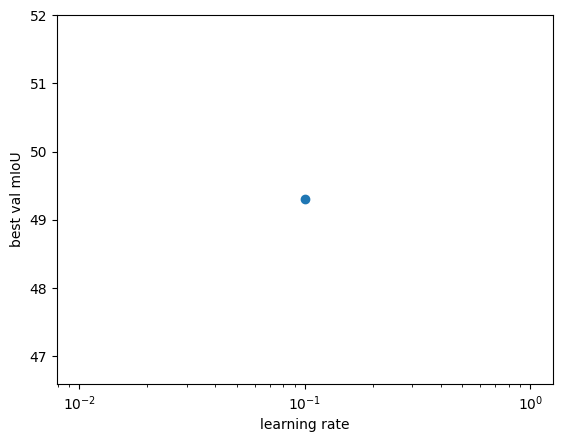

,work_dir,log_run,backbone,pretrained,checkpoint,load_from,auxhead,train_dataset,train_iters,test_dataset,test_mode,batch_size,learning_rate,weight_decay,momentum,decode_loss_name,class_weight,prompt_depth,prompt_length,prompt_dropout,memory_file,total_parameters,trainable_parameters,trainable_parameters_percentage,duration,train_run_info,val_run_info,test_run_info,best_val_info
13,setrvpt_vit-l_pup_8xb2-160k_ade20k-512x512,20231120_011426,PromptedVisionTransformer,True,pretrain/vit_large_p16.pth,,True,ADE20KDataset,160000,ADE20KDataset,slide,4,0.0005,0.0,0.9,CrossEntropyLoss,(),24.0,50.0,0.1,None,NaN,NaN,NaN,2 days 05:50:09,"[{'base_lr': 0.0004998897476225205, 'lr': 0.00...","[{'aAcc': 73.44, 'mIoU': 13.78, 'mAcc': 19.44,...","{'aAcc': 80.94, 'mIoU': 40.55, 'mAcc': 52.68, ...","{'aAcc': 80.95, 'mIoU': 40.56, 'mAcc': 52.66, ..."


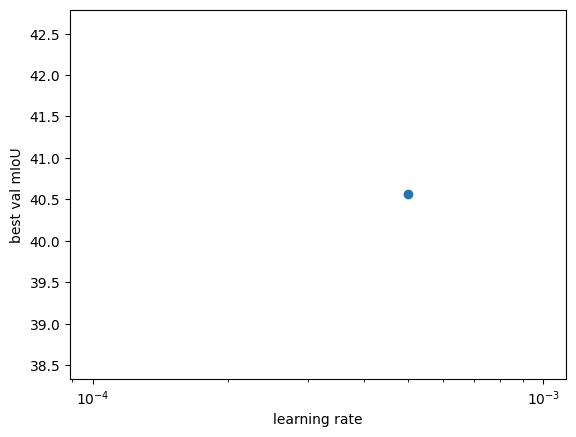

,work_dir,log_run,backbone,pretrained,checkpoint,load_from,auxhead,train_dataset,train_iters,test_dataset,test_mode,batch_size,learning_rate,weight_decay,momentum,decode_loss_name,class_weight,prompt_depth,prompt_length,prompt_dropout,memory_file,total_parameters,trainable_parameters,trainable_parameters_percentage,duration,train_run_info,val_run_info,test_run_info,best_val_info
22,setrvpt_vit-l_pup_8xb2-160k_cbis-ddsm-multi-51...,20231211_143901,PromptedVisionTransformer,True,pretrain/vit_large_p16.pth,,True,CBISMultiDataset,160000,CBISMultiDataset,whole,4,0.1,0.001,0.9,CrossEntropyLoss,(),24.0,50.0,0.1,/home/drumsnchocolate/Documents/Studie/Master/...,318369812.0,14223380.0,0.044676,1 days 17:35:54,"[{'base_lr': 0.09997246446872429, 'lr': 0.0999...","[{'aAcc': 98.6, 'mIoU': 19.72, 'mAcc': 20.0, '...","{'aAcc': 98.76, 'mIoU': 19.75, 'mAcc': 20.0, '...","{'aAcc': 98.6, 'mIoU': 19.72, 'mAcc': 20.0, 'd..."


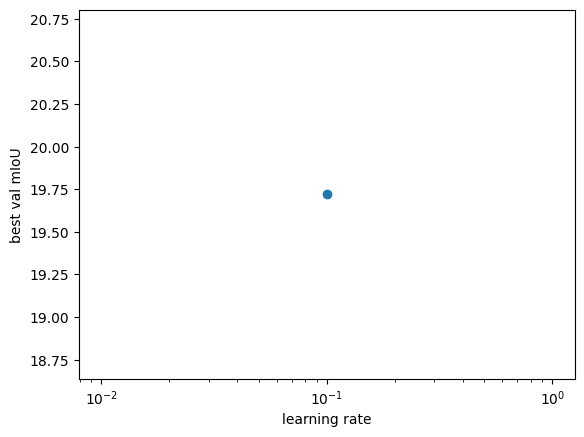

,work_dir,log_run,backbone,pretrained,checkpoint,load_from,auxhead,train_dataset,train_iters,test_dataset,test_mode,batch_size,learning_rate,weight_decay,momentum,decode_loss_name,class_weight,prompt_depth,prompt_length,prompt_dropout,memory_file,total_parameters,trainable_parameters,trainable_parameters_percentage,duration,train_run_info,val_run_info,test_run_info,best_val_info
0,setr_vit-l_pup_8xb2-160k_cbis-ddsm-binary-512x512,20231226_135805,VisionTransformer,True,pretrain/vit_large_p16.pth,,True,CBISBinaryDataset,160000,CBISBinaryDataset,whole,4,0.0500,0.001,0.9,CrossEntropyLoss,"(0.04, 1.96)",NaN,NaN,NaN,/home/drumsnchocolate/Documents/Studie/Master/...,317137928.0,317137928.0,1.0,1 days 15:30:29,"[{'base_lr': 0.04998624601590929, 'lr': 0.0499...","[{'aAcc': 98.6, 'mIoU': 49.3, 'mAcc': 50.0, 'd...",None,"{'aAcc': 98.6, 'mIoU': 49.3, 'mAcc': 50.0, 'da..."
7,setr_vit-l_pup_8xb2-160k_cbis-ddsm-binary-512x512,20231226_143637,VisionTransformer,True,pretrain/vit_large_p16.pth,,True,CBISBinaryDataset,160000,CBISBinaryDataset,whole,4,0.0100,0.001,0.9,CrossEntropyLoss,"(0.04, 1.96)",NaN,NaN,NaN,/home/drumsnchocolate/Documents/Studie/Master/...,317137928.0,317137928.0,1.0,1 days 17:04:38,"[{'base_lr': 0.009997271253657354, 'lr': 0.009...","[{'aAcc': 80.94, 'mIoU': 43.1, 'mAcc': 80.0, '...",None,"{'aAcc': 93.03, 'mIoU': 51.19, 'mAcc': 72.68, ..."
6,setr_vit-l_pup_8xb2-160k_cbis-ddsm-binary-512x512,20231226_150625,VisionTransformer,True,pretrain/vit_large_p16.pth,,True,CBISBinaryDataset,160000,CBISBinaryDataset,whole,4,0.0050,0.001,0.9,CrossEntropyLoss,"(0.04, 1.96)",NaN,NaN,NaN,/home/drumsnchocolate/Documents/Studie/Master/...,317137928.0,317137928.0,1.0,1 days 16:10:22,"[{'base_lr': 0.0049986494083758635, 'lr': 0.00...","[{'aAcc': 91.77, 'mIoU': 50.01, 'mAcc': 72.9, ...",None,"{'aAcc': 97.13, 'mIoU': 53.73, 'mAcc': 60.95, ..."
5,setr_vit-l_pup_8xb2-160k_cbis-ddsm-binary-512x512,20231226_194003,VisionTransformer,True,pretrain/vit_large_p16.pth,,True,CBISBinaryDataset,160000,CBISBinaryDataset,whole,4,0.0010,0.001,0.9,CrossEntropyLoss,"(0.04, 1.96)",NaN,NaN,NaN,/home/drumsnchocolate/Documents/Studie/Master/...,317137928.0,317137928.0,1.0,1 days 16:53:20,"[{'base_lr': 0.000999751932150666, 'lr': 0.000...","[{'aAcc': 94.03, 'mIoU': 52.19, 'mAcc': 72.13,...",None,"{'aAcc': 97.86, 'mIoU': 53.62, 'mAcc': 57.44, ..."
4,setr_vit-l_pup_8xb2-160k_cbis-ddsm-binary-512x512,20231227_165153,VisionTransformer,True,pretrain/vit_large_p16.pth,,True,CBISBinaryDataset,160000,CBISBinaryDataset,whole,4,0.0001,0.001,0.9,CrossEntropyLoss,"(0.04, 1.96)",NaN,NaN,NaN,/home/drumsnchocolate/Documents/Studie/Master/...,317137928.0,317137928.0,1.0,1 days 16:36:58,"[{'base_lr': 0.0001, 'lr': 0.0001, 'data_time'...","[{'aAcc': 91.28, 'mIoU': 49.44, 'mAcc': 71.85,...",None,"{'aAcc': 97.34, 'mIoU': 53.77, 'mAcc': 60.04, ..."
3,setr_vit-l_pup_8xb2-160k_cbis-ddsm-binary-512x512,20231212_141502,VisionTransformer,True,pretrain/vit_large_p16.pth,,True,CBISBinaryDataset,160000,CBISBinaryDataset,whole,4,0.0010,0.000,0.9,CrossEntropyLoss,"(0.04, 1.96)",NaN,NaN,NaN,/home/drumsnchocolate/Documents/Studie/Master/...,317137928.0,317137928.0,1.0,1 days 16:32:25,"[{'base_lr': 0.000999751932150666, 'lr': 0.000...","[{'aAcc': 96.76, 'mIoU': 54.07, 'mAcc': 63.79,...","{'aAcc': 98.56, 'mIoU': 54.09, 'mAcc': 56.01, ...","{'aAcc': 98.09, 'mIoU': 54.38, 'mAcc': 57.81, ..."
2,setr_vit-l_pup_8xb2-160k_cbis-ddsm-binary-512x512,20231227_020743,VisionTransformer,True,pretrain/vit_large_p16.pth,,True,CBISBinaryDataset,160000,CBISBinaryDataset,whole,4,0.0005,0.001,0.9,CrossEntropyLoss,"(0.04, 1.96)",NaN,NaN,NaN,/home/drumsnchocolate/Documents/Studie/Master/...,317137928.0,317137928.0,1.0,1 days 17:12:41,"[{'base_lr': 0.0004998897476225205, 'lr': 0.00...","[{'aAcc': 90.6, 'mIoU': 49.13, 'mAcc': 73.74, ...",None,"{'aAcc': 98.17, 'mIoU': 54.14, 'mAcc': 57.06, ..."
1,setr_vit-l_pup_8xb2-160k_cbis-ddsm-binary-512x512,20231226_130135,VisionTransformer,True,pretrain/vit_large_p16.pth,,True,CBISBinary

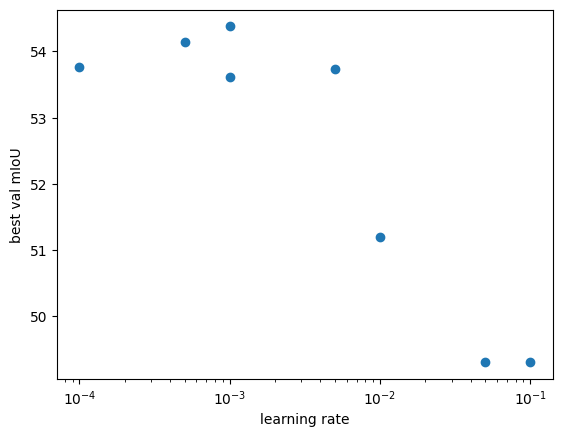

,work_dir,log_run,backbone,pretrained,checkpoint,load_from,auxhead,train_dataset,train_iters,test_dataset,test_mode,batch_size,learning_rate,weight_decay,momentum,decode_loss_name,class_weight,prompt_depth,prompt_length,prompt_dropout,memory_file,total_parameters,trainable_parameters,trainable_parameters_percentage,duration,train_run_info,val_run_info,test_run_info,best_val_info
9,setr_vit-l_pup-noaux_8xb2-160k_ade20k-512x512,20231119_220357,VisionTransformer,True,pretrain/vit_large_p16.pth,,False,ADE20KDataset,160000,ADE20KDataset,slide,8,0.001,0.0,0.9,CrossEntropyLoss,(),NaN,NaN,NaN,None,NaN,NaN,NaN,3 days 02:53:09,"[{'base_lr': 0.000999751932150666, 'lr': 0.000...","[{'aAcc': 79.64, 'mIoU': 40.66, 'mAcc': 53.44,...","{'aAcc': 82.32, 'mIoU': 48.14, 'mAcc': 60.29, ...","{'aAcc': 82.32, 'mIoU': 48.14, 'mAcc': 60.29, ..."
10,setr_vit-l_pup-noaux_8xb2-160k_ade20k-512x512,20231208_113210,VisionTransformer,True,pretrain/vit_large_p16.pth,,False,ADE20KDataset,160000,ADE20KDataset,slide,4,0.001,0.0,0.9,CrossEntropyLoss,(),NaN,NaN,NaN,None,308317846.0,308317846.0,1.0,1 days 15:20:52,"[{'base_lr': 0.000999751932150666, 'lr': 0.000...","[{'aAcc': 76.3, 'mIoU': 33.94, 'mAcc': 47.9, '...","{'aAcc': 82.08, 'mIoU': 46.88, 'mAcc': 59.49, ...","{'aAcc': 82.08, 'mIoU': 46.88, 'mAcc': 59.49, ..."


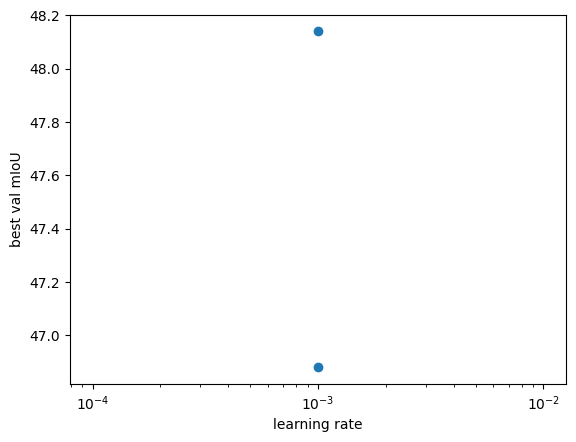

,work_dir,log_run,backbone,pretrained,checkpoint,load_from,auxhead,train_dataset,train_iters,test_dataset,test_mode,batch_size,learning_rate,weight_decay,momentum,decode_loss_name,class_weight,prompt_depth,prompt_length,prompt_dropout,memory_file,total_parameters,trainable_parameters,trainable_parameters_percentage,duration,train_run_info,val_run_info,test_run_info,best_val_info
8,setr_vit-l_pup_8xb2-160k_cbis-ddsm-binary-512x512,20231207_151546,VisionTransformer,True,pretrain/vit_large_p16.pth,,True,CBISBinaryDataset,160000,CBISBinaryDataset,whole,4,0.001,0.0,0.9,CrossEntropyLoss,(),NaN,NaN,NaN,/home/drumsnchocolate/Documents/Studie/Master/...,317137928.0,317137928.0,1.0,1 days 16:32:56,"[{'base_lr': 0.000999751932150666, 'lr': 0.000...","[{'aAcc': 98.35, 'mIoU': 52.42, 'mAcc': 53.91,...","{'aAcc': 98.1, 'mIoU': 53.54, 'mAcc': 57.14, '...","{'aAcc': 98.08, 'mIoU': 54.22, 'mAcc': 57.56, ..."


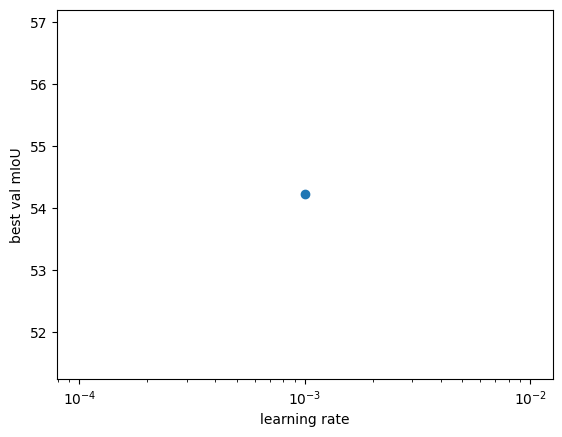

,work_dir,log_run,backbone,pretrained,checkpoint,load_from,auxhead,train_dataset,train_iters,test_dataset,test_mode,batch_size,learning_rate,weight_decay,momentum,decode_loss_name,class_weight,prompt_depth,prompt_length,prompt_dropout,memory_file,total_parameters,trainable_parameters,trainable_parameters_percentage,duration,train_run_info,val_run_info,test_run_info,best_val_info
23,setr_vit-l_pup_8xb2-160k_ade20k-512x512,20231119_220403,VisionTransformer,True,pretrain/vit_large_p16.pth,,True,ADE20KDataset,160000,ADE20KDataset,slide,4,0.001,0.0,0.9,CrossEntropyLoss,(),NaN,NaN,NaN,None,NaN,NaN,NaN,2 days 04:13:26,"[{'base_lr': 0.000999751932150666, 'lr': 0.000...","[{'aAcc': 76.92, 'mIoU': 32.62, 'mAcc': 43.89,...","{'aAcc': 82.2, 'mIoU': 46.68, 'mAcc': 59.55, '...","{'aAcc': 82.2, 'mIoU': 46.68, 'mAcc': 59.55, '..."


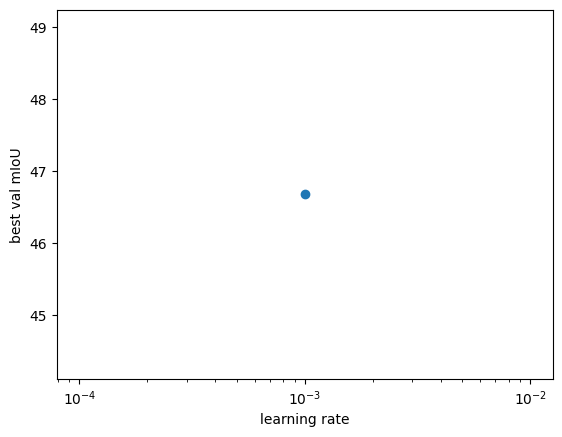

In [7]:
# let's show individual dataframes for each combination of train_dataset, backbone, pretrained, checkpoint, load_from, auxhead, train_iters
print(logs_df.columns)
filter_columns = ['train_dataset', 'backbone', 'pretrained', 'checkpoint', 'load_from', 'auxhead', 'train_iters', 'class_weight']
unique_combinations = logs_df[filter_columns].drop_duplicates()
for _, unique_combination in unique_combinations.iterrows():
    matching_logs_df = logs_df[(logs_df[filter_columns].apply(lambda row: (row == unique_combination).all(), axis=1))]
    display(matching_logs_df)
    # plot the best validation mIoU for different learning_rates
    lrs = matching_logs_df['learning_rate']
    best_val_infos = matching_logs_df['best_val_info']
    best_val_mIoUs = best_val_infos.apply(lambda info: info['mIoU'])
    plt.scatter(lrs, best_val_mIoUs)
    # x scale log
    plt.xscale('log')
    plt.xlabel('learning rate')
    plt.ylabel('best val mIoU')
    plt.show()